## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the Telecom dataset

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Load library
import numpy as np
import pandas as pd

In [2]:
#Read data file
Telecom_data = pd.read_csv("telecom_churn_data.csv")
# Check the head of the dataset
Telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


Inspecting Telecom dataframe for different attributes

In [3]:
Telecom_data.shape

(99999, 226)

In [4]:
Telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
Telecom_data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

## Step 2: Data Cleaning and Preparation

### 2.a Deriving new features 

In [6]:
Recharge_cols = [col for col in Telecom_data.columns if 'total_rech_' in col]
Recharge_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_num_9',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9']

In [7]:
# Deriving Total recharge amount variables using Total_Recharge and Recharge_Amt

Telecom_data['total_rech_data_amt_6'] = Telecom_data['total_rech_data_6']*Telecom_data['av_rech_amt_data_6']

Telecom_data['total_rech_data_amt_7'] = Telecom_data['total_rech_data_7']*Telecom_data['av_rech_amt_data_7']

Telecom_data['total_rech_data_amt_8'] = Telecom_data['total_rech_data_8']*Telecom_data['av_rech_amt_data_8']

Telecom_data['total_rech_data_amt_9'] = Telecom_data['total_rech_data_9']*Telecom_data['av_rech_amt_data_9']



# Removing old columns
Telecom_data = Telecom_data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
                                 'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],
                                 axis = 1)

#### 70th percentile avg recharge amount

In [8]:
# Avg. recharge amount in the first two months - in our case 6th and 7th month

av_rech_amt_2months_6th_and_7th = (Telecom_data['total_rech_amt_6'].fillna(0) +
                                   Telecom_data['total_rech_data_amt_6'].fillna(0) +
                                   Telecom_data['total_rech_amt_7'].fillna(0) +
                                   Telecom_data['total_rech_data_amt_7'].fillna(0))/2.0

# 70th percentile value
Percentile_70_6th_7th_month = np.percentile(av_rech_amt_2months_6th_and_7th, 70.0) 
Percentile_70_6th_7th_month

478.0

### 2.b Filter, High Value Customers 
(i.e., customers, who have recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months (the good phase))

In [9]:
# create a new feature to define high value customers (HVC)
Telecom_HVC = Telecom_data[av_rech_amt_2months_6th_and_7th >= Percentile_70_6th_7th_month]
Telecom_HVC.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,NaN,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,NaN,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,NaN,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,1.0,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0


### 2.c Tag churners and remove attributes of the churn phase

In [10]:
Telecom_HVC[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
21,252.61,1031.53,0.00,0.00
23,127.48,127.63,13.93,314.74


In [11]:
#churned customers (with churn = 1 otherwise 0)
Telecom_HVC['churn'] = np.where(Telecom_HVC[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)==0,1,0)

In [12]:
Telecom_HVC['churn'].head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int32

### 2.d Removing null values and not important columns

In [13]:
# droping all 9th month related columns
drop_9thmonth_cols = [col for col in Telecom_HVC.columns if '_9' in col]

Telecom_HVC = Telecom_HVC.drop(drop_9thmonth_cols, axis = 1)

In [14]:
#Drop unecessary rows using columns with high NaN percentages

Large_NAN_cols = Telecom_HVC.columns[Telecom_HVC.isnull().sum()/Telecom_HVC.shape[0]*100 > 25]
Large_NAN_cols

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'total_rech_data_amt_6', 'total_rech_data_amt_7',
       'total_rech_data_amt_8'],
      dtype='object')

In [15]:
# Get the column-wise Null count using 'is.null()' alongwith the 'sum()' function
Telecom_HVC.apply(lambda x: sum(x.isnull()))

mobile_number                0
circle_id                    0
loc_og_t2o_mou             224
std_og_t2o_mou             224
loc_ic_t2o_mou             224
                         ...  
sep_vbc_3g                   0
total_rech_data_amt_6    13245
total_rech_data_amt_7    12944
total_rech_data_amt_8    14048
churn                        0
Length: 170, dtype: int64

In [16]:
# Get the percentages by dividing the sum obtained previously by the total length, multiplying it by 100 and rounding it off to two decimal places

round(100*(Telecom_HVC.isnull().sum()/len(Telecom_HVC.index)), 2)

mobile_number             0.00
circle_id                 0.00
loc_og_t2o_mou            0.75
std_og_t2o_mou            0.75
loc_ic_t2o_mou            0.75
                         ...  
sep_vbc_3g                0.00
total_rech_data_amt_6    44.15
total_rech_data_amt_7    43.15
total_rech_data_amt_8    46.83
churn                     0.00
Length: 170, dtype: float64

In [17]:
# Use the 'drop()' function to drop the unnecessary columns

Telecom_HVC = Telecom_HVC.drop(Large_NAN_cols,axis = 1)

In [18]:
Telecom_HVC.shape

(30001, 143)

In [19]:
#Remove data with only 1 unique value
Telecom_HVC = Telecom_HVC.loc[:,Telecom_HVC.apply(pd.Series.nunique)!=1]

In [20]:
# Get the row-wise Null count using 'is.null()' alongwith the 'sum(axis=1)' function
Telecom_HVC.isnull().sum(axis=1)

0        54
7         0
8         0
21        0
23        0
         ..
99981     0
99984     0
99986     0
99988     0
99997     0
Length: 30001, dtype: int64

In [21]:
# The rows for which the sum of Null is less than hundred are retained

Telecom_HVC = Telecom_HVC[Telecom_HVC.isnull().sum(axis=1) <= 100]
Telecom_HVC.head(5)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,...,1,0,0,0,968,30.40,0.00,101.20,3.58,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,0,0,0,0,802,57.74,19.38,18.74,0.00,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,0,0,0,0,315,21.03,910.65,122.16,0.00,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,0,0,0,0,720,0.00,0.00,0.00,0.00,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,1,0,0,1,604,40.45,51.86,0.00,0.00,0


In [22]:
#Drop the duplicate values using 'drop_duplicates' function. All the columns for duplicate rows need to be dropped and thus,
# the 'subset' argument is set to 'None'. The 'keep = first' indicates to retain the first row among the duplicate rows, and
# 'inplace = True' performs the operation on the dataframe in place.

Telecom_HVC.drop_duplicates(subset = None, keep = 'first', inplace = True)

In [23]:
#dividing numerical and categorical columns 
cols = Telecom_HVC.columns
numerical_cols = Telecom_HVC._get_numeric_data().columns
categorical_cols = list(set(cols) - set(numerical_cols))

#List of categorical columns
categorical_cols

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [24]:
#get a list of numerical columns
numerical_cols

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8',
       ...
       'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'churn'],
      dtype='object', length=127)

In [25]:
# Given categorical cols are datetime: change the datatype to datetime
for col in categorical_cols:
    Telecom_HVC[col] = pd.to_datetime(Telecom_HVC[col])

In [26]:
Telecom_HVC.shape

(30001, 130)

In [27]:
#Removing time stamp columns
Telecom_HVC = Telecom_HVC.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],
                                 axis = 1)

## Step 3: New Column/Feature creation
Taking average of 6th and 7th column, as both are part of 'Good' phase

In [28]:
temp_col_list1 = Telecom_HVC.filter(regex='_6|_7').columns.str[:-2]
temp_col_list1.unique()

print (Telecom_HVC.shape)

for idx, col in enumerate(temp_col_list1.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    Telecom_HVC[avg_col_name] = (Telecom_HVC[col_6]  + Telecom_HVC[col_7])/ 2

(30001, 127)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
loc_ic_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
std_ic_mou
total_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g


In [29]:
# droping 6th and 7th month attributes as we have replaced them by its average.
temp_col_lst2 = Telecom_HVC.filter(regex='_6|_7').columns

Telecom_HVC.drop(temp_col_lst2, axis=1, inplace=True)

In [30]:
Telecom_HVC.shape

(30001, 87)

## Step 4: EDA

### Visualising the Data

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
cols = Telecom_HVC.columns
numerical_cols_new = Telecom_HVC._get_numeric_data().columns

Text(0.5, 1, 'Correlation of numerical columns for Telecom dataframe')

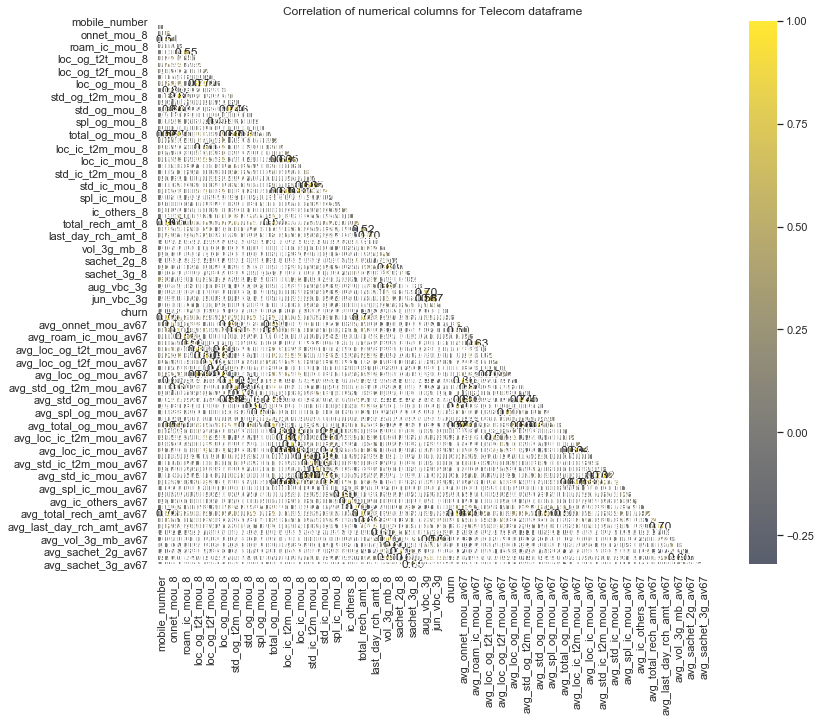

In [33]:
Telecom_HVC_heatmap = Telecom_HVC[numerical_cols_new]

from string import ascii_letters
sns.set(style="white")
# Compute the correlation matrix
corr = Telecom_HVC_heatmap.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='cividis', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1},annot=True, fmt='.2f')
plt.title('Correlation of numerical columns for Telecom dataframe')

In [34]:
#Removing top correlating variables
corr = Telecom_HVC_heatmap.corr().abs()

# Generate a mask for the upper triangle
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

#Find index of high correlating columns
drop_high_corr_cols = [column for column in upper.columns if any(upper[column]>0.75)]

#drop high correlating features
Telecom_HVC = Telecom_HVC.drop(Telecom_HVC[drop_high_corr_cols], axis = 1)

In [35]:
Telecom_HVC.shape

(30001, 58)

In [36]:
Telecom_HVC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 58 columns):
mobile_number                30001 non-null int64
arpu_8                       30001 non-null float64
onnet_mou_8                  28827 non-null float64
offnet_mou_8                 28827 non-null float64
roam_ic_mou_8                28827 non-null float64
roam_og_mou_8                28827 non-null float64
loc_og_t2t_mou_8             28827 non-null float64
loc_og_t2m_mou_8             28827 non-null float64
loc_og_t2f_mou_8             28827 non-null float64
loc_og_t2c_mou_8             28827 non-null float64
std_og_t2f_mou_8             28827 non-null float64
isd_og_mou_8                 28827 non-null float64
spl_og_mou_8                 28827 non-null float64
og_others_8                  28827 non-null float64
loc_ic_t2t_mou_8             28827 non-null float64
loc_ic_t2m_mou_8             28827 non-null float64
loc_ic_t2f_mou_8             28827 non-null float64
std_ic_t2

### Checking for Outliers

In [37]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
Telecom_HVC.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67
count,3.000100e+04,30001.000000,28827.000000,28827.000000,28827.000000,28827.000000,28827.000000,28827.000000,28827.000000,28827.000000,...,29219.000000,29219.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,7.001206e+09,508.597957,243.646938,348.723294,13.009645,20.674656,81.256858,157.937216,6.126112,1.777295,...,11.451043,1.356895,11.784924,170.743275,100.624813,125.809755,0.178877,1.140045,0.223393,0.218443
std,6.908784e+05,501.961981,465.200856,486.918550,75.575865,106.751862,231.399901,236.315181,19.858510,7.345047,...,73.946966,13.906859,8.634676,154.193137,115.928063,300.031016,0.387763,2.414776,0.571149,0.947966
min,7.000000e+09,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000609e+09,231.473000,14.255000,58.670000,0.000000,0.000000,3.830000,17.530000,0.000000,0.000000,...,0.000000,0.000000,6.500000,102.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001203e+09,427.585000,72.930000,197.590000,0.000000,0.000000,23.240000,74.540000,0.000000,0.000000,...,0.000000,0.000000,9.500000,128.000000,77.000000,6.220000,0.000000,0.000000,0.000000,0.000000
75%,7.001804e+09,661.491000,255.025000,455.385000,0.000000,0.000000,76.040000,205.860000,4.260000,0.110000,...,0.545000,0.240000,14.500000,200.000000,124.000000,107.910000,0.000000,1.000000,0.000000,0.000000
90%,7.002165e+09,977.345000,685.236000,843.680000,16.530000,31.698000,184.310000,408.672000,15.740000,4.860000,...,16.545000,1.805000,22.000000,300.000000,200.000000,395.055000,1.000000,4.000000,1.000000,0.500000
95%,7.002285e+09,1255.019000,1097.425000,1186.968000,59.472000,106.280000,307.824000,582.823000,29.360000,9.700000,...,45.801500,4.690500,28.000000,452.000000,259.500000,651.505000,1.000000,6.000000,1.500000,1.000000
99%,7.002386e+09,1986.622000,2187.486400,2225.787200,288.156000,438.226200,935.870000,1100.020800,84.006600,28.856600,...,230.976000,19.760500,44.500000,799.500000,550.000000,1376.720000,1.500000,11.000000,2.500000,4.000000


We can see outliers in almost every attribute. We will take care of them during feature scaling

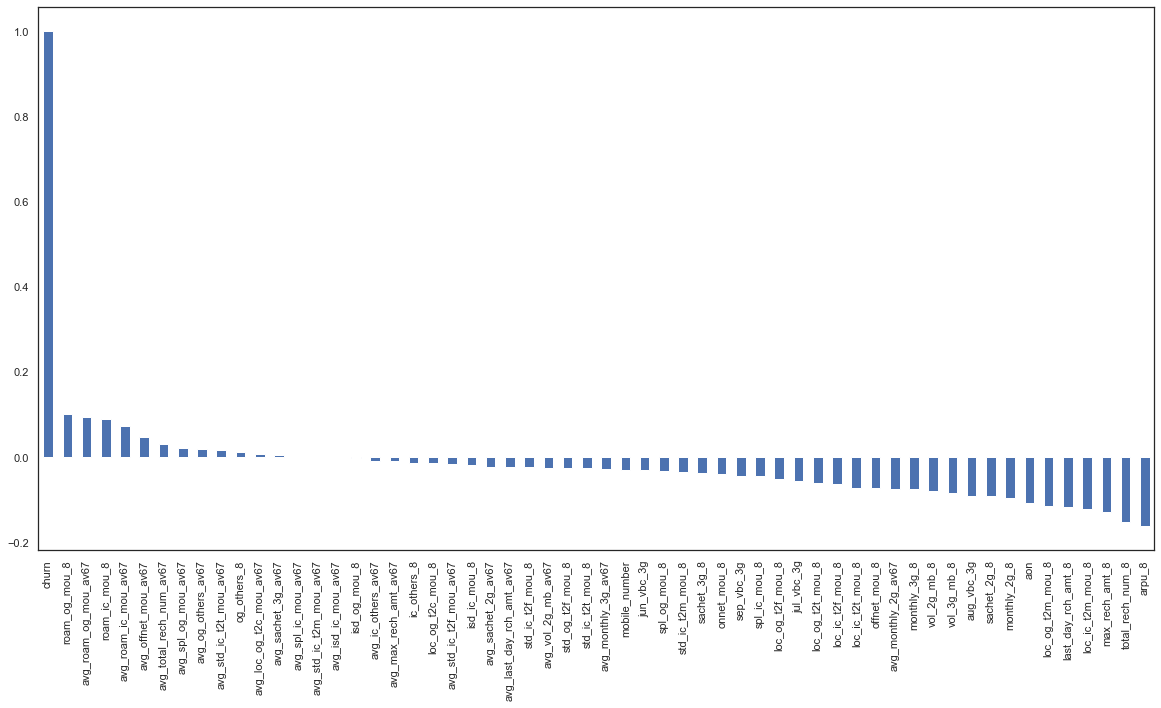

In [38]:
# Correlation of Churn with attributes
plt.figure(figsize=(20,10))
Telecom_HVC.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

- Attributes "roam_og_mou_8", "avg_roam_og_mou_av67", "roam_ic_mou_8",avg_roam_ic_mou_av67" etc shows high positive correlation.
- Attributes "arpu_8", "total_rech_num_8", "max_rech_amt_8", "loc_ic_t2m_mou_8" etc shows high negative correlation.

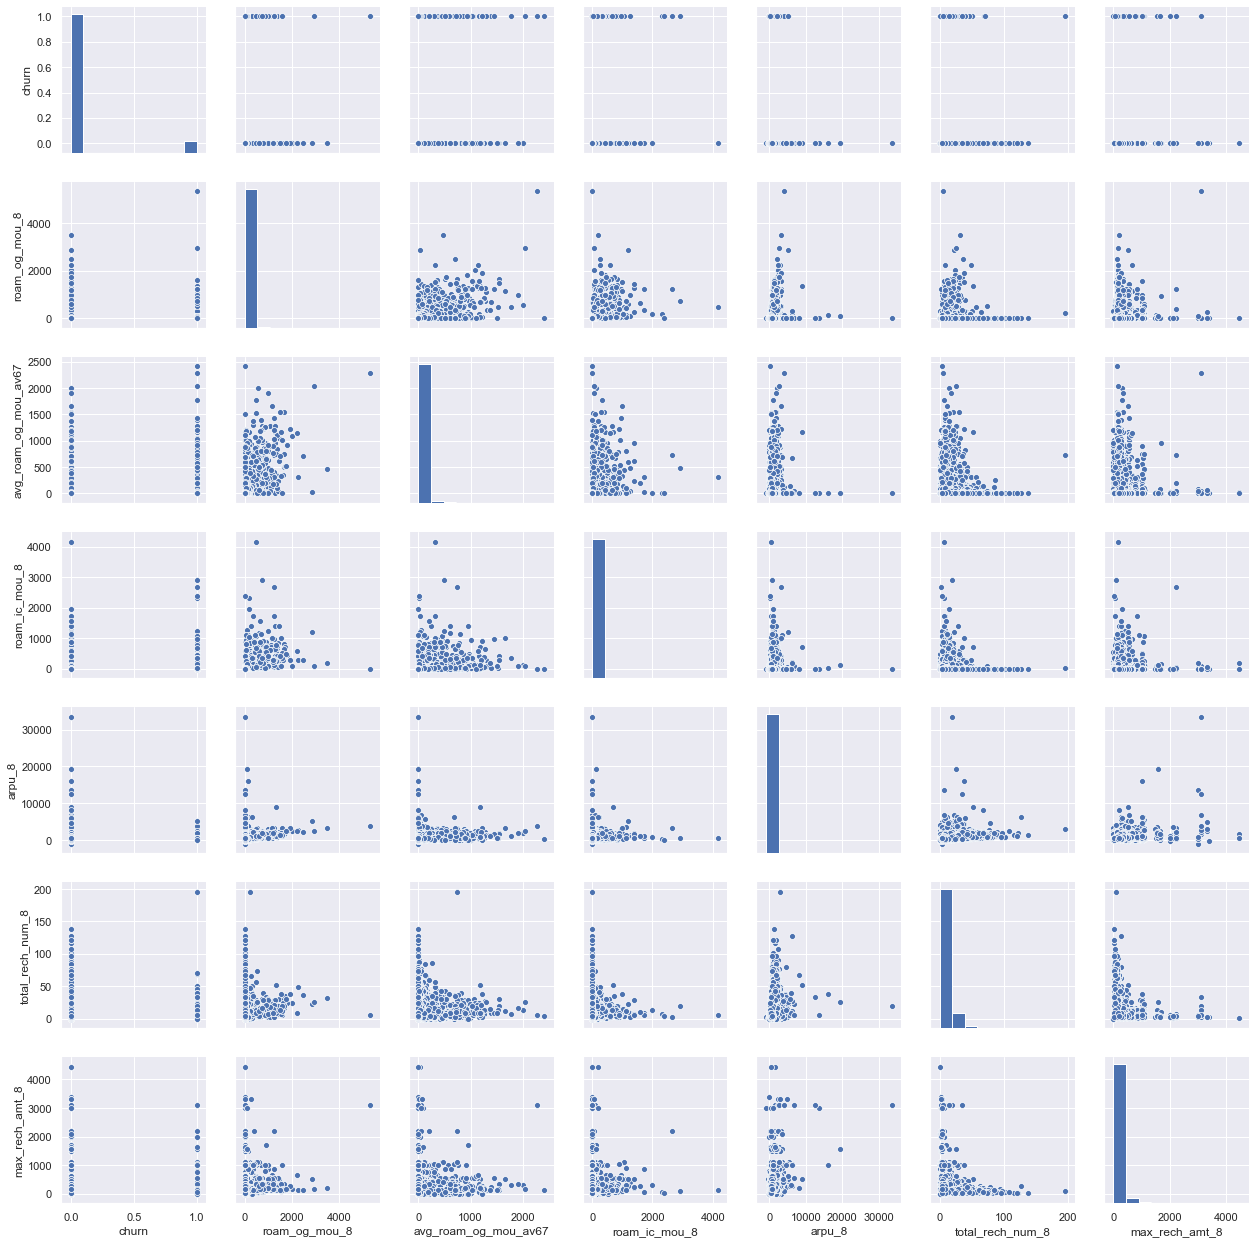

In [39]:
#scatterplot
sns.set()
cols = ['churn', 'roam_og_mou_8', 'avg_roam_og_mou_av67', 'roam_ic_mou_8', 'arpu_8', 'total_rech_num_8', 'max_rech_amt_8']
sns.pairplot(Telecom_HVC[cols], size = 2.5)
plt.show();

In [40]:
# Checking the Churn Rate
churn = (sum(Telecom_HVC['churn'])/len(Telecom_HVC['churn'].index))*100
round(churn,2)

8.14

## Step 5: Splitting the Data into Training and Testing Sets

In [41]:
#importing all required libraries
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [42]:
#Creating a copy for building our model
Telecom_model = Telecom_HVC[:].copy()

In [43]:
Telecom_model = Telecom_model.drop('mobile_number',axis=1)

Telecom_model = Telecom_model.fillna(0)

#### 5a. Dividing into X and Y sets for the model building

In [44]:
# Putting feature variable to X
X = Telecom_model.drop(['churn'], axis=1)

X.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2f_mou_8,...,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,3.5,252.0,252.0,15.725,0.0,0.0,1.0,0.0
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,16.68,...,8.295,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,0.00,...,0.000,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,0.00,...,0.000,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,...,14.115,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0


In [45]:
# Putting response variable to y
y = Telecom_model['churn']

y.head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int32

#### 5b. Rescaling the Features - we will use MinMax scaler

In [46]:
numerical_cols = X._get_numeric_data().columns
numerical_cols

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2c_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67',

In [47]:
#Scaling variables
scaler=StandardScaler()


scaler_vars=['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2c_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67', 'avg_total_rech_num_av67',
       'avg_max_rech_amt_av67', 'avg_last_day_rch_amt_av67',
       'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67',
       'avg_monthly_3g_av67', 'avg_sachet_3g_av67']


#Scaling train set
X[scaler_vars]= scaler.fit_transform(X[scaler_vars])

In [48]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

#### 5c. Treating imbalance

In [49]:
X_train.shape

(21000, 56)

In [50]:
X_test.shape

(9001, 56)

In [118]:
X_test_cols = X_test.columns
X_test_cols

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2c_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67',

In [51]:
#checking imbalance in y
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

Before OverSampling, counts of label '1': 1691
Before OverSampling, counts of label '0': 19309 



In [52]:
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

In [53]:
#checking imbalance in y again
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


After OverSampling, the shape of train_X: (38618, 56)
After OverSampling, the shape of train_y: (38618,) 

After OverSampling, counts of label '1': 19309
After OverSampling, counts of label '0': 19309


## Step 6: Building a model

#### 6a. Support Vector Machine

In [54]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.9166759248972336

#### 6b. RFE

In [55]:
# Feature reduction using RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE

# running RFE with 10 variables as output
rfe = RFE(logreg, 10)   
rfe = rfe.fit(X_train_res, y_train_res)

In [56]:
rfe.support_

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False])

In [57]:
rfe_features = list(X_train.columns[rfe.support_])
print("Features identified by RFE ", rfe_features)

Features identified by RFE  ['loc_og_t2m_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'total_rech_num_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'sep_vbc_3g', 'avg_total_rech_num_av67']


In [58]:
X_rfe = pd.DataFrame(data=X_train_res).iloc[:, rfe.support_]
y_rfe = y_train_res

#### 6b.1 Logistic Regression using RFE

In [59]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
# Weightage of variables
weights = pd.Series(lr.coef_[0],
                 index=rfe_features)
weights.sort_values(ascending = False)

avg_total_rech_num_av67    0.727020
monthly_2g_8              -0.582035
sachet_2g_8               -0.591889
vol_2g_mb_8               -0.704411
loc_ic_t2f_mou_8          -0.730264
loc_og_t2m_mou_8          -0.911744
loc_ic_t2m_mou_8          -1.007460
total_rech_num_8          -1.186320
loc_ic_t2t_mou_8          -1.227024
sep_vbc_3g                -1.406300
dtype: float64

In [61]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6360 1891]
 [ 128  622]]


In [62]:
print('Log Regressionmodel accuracy on test set with RFE is ',lr.score(X_test_rfe, y_test))

Log Regressionmodel accuracy on test set with RFE is  0.775691589823353


In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      8251
           1       0.25      0.83      0.38       750

    accuracy                           0.78      9001
   macro avg       0.61      0.80      0.62      9001
weighted avg       0.92      0.78      0.82      9001



#### Key results from RFE: 

    1. Logistic regression model accuracy c.78%
    2. High false positive in confusion matrix suggests that model is not predicting churn properly

#### 6c. PCA

In [64]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [65]:
#Doing the PCA on the train data
pca.fit(X_train_res)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

In [66]:
pca.components_

array([[ 0.25345986,  0.08770531,  0.13868904, ..., -0.11348579,
         0.07322119, -0.03959277],
       [-0.17713739, -0.02345042, -0.06990634, ...,  0.05431208,
        -0.21381968, -0.01800917],
       [ 0.25404288,  0.20478032,  0.3055058 , ...,  0.04026002,
        -0.16387195,  0.02242969],
       ...,
       [ 0.00204646,  0.10835978,  0.39596151, ..., -0.00758999,
         0.25349063, -0.06295983],
       [-0.32146635,  0.03647467, -0.07338897, ...,  0.26723564,
         0.16893621,  0.0258842 ],
       [-0.61697284,  0.22194713,  0.36144065, ..., -0.07844227,
        -0.13563589, -0.02992696]])

In [67]:
X_train_pca = pca.fit_transform(X_train_res)
print(X_train_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(38618, 56)
(9001, 56)


#### 6c.1 Logistic Regression with PCA

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_train_pca, y_train_res)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[6797 1454]
 [ 124  626]]


In [70]:
print('Log Regressionmodel accuracy on test set with PCA is ',accuracy_score(y_test,y_pred))

Log Regressionmodel accuracy on test set with PCA is  0.8246861459837795


In [71]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':colnames})
pcs_df.head()

,PC1,PC2,PC3,Feature
0,0.253460,-0.177137,0.254043,arpu_8
1,0.087705,-0.023450,0.204780,onnet_mou_8
2,0.138689,-0.069906,0.305506,offnet_mou_8
3,0.325418,0.307500,-0.085513,roam_ic_mou_8
4,0.355468,0.233062,-0.013881,roam_og_mou_8


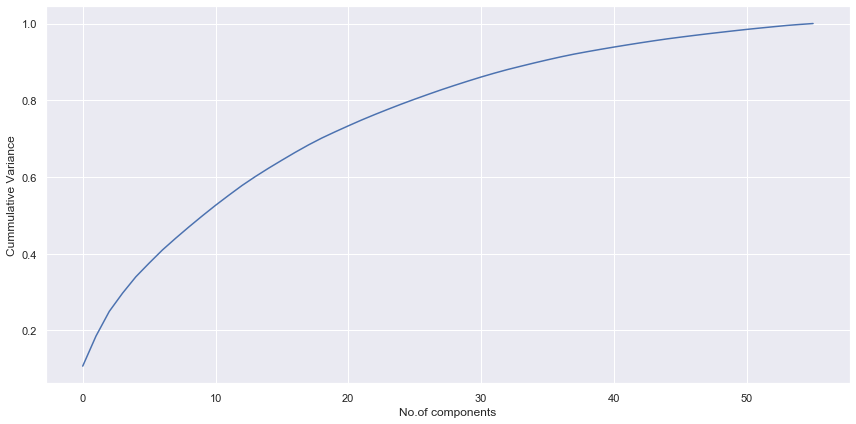

In [72]:
%matplotlib inline
fig = plt.figure(figsize = (12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No.of components')
plt.ylabel('Cummulative Variance')
plt.tight_layout()
plt.show()

In [73]:
pca.explained_variance_ratio_

array([0.10695571, 0.07837588, 0.0642665 , 0.0475399 , 0.04265878,
       0.03557053, 0.03427715, 0.03069905, 0.02956812, 0.0285402 ,
       0.02764339, 0.02625494, 0.02551767, 0.02325401, 0.02184254,
       0.02081526, 0.02038375, 0.019371  , 0.01790829, 0.01619548,
       0.01563892, 0.01521702, 0.01437252, 0.01377415, 0.01338793,
       0.01278101, 0.01238424, 0.0120813 , 0.01147869, 0.01107987,
       0.01073782, 0.01007528, 0.00948636, 0.00864187, 0.00846812,
       0.00810285, 0.00776133, 0.00715129, 0.00638932, 0.00609933,
       0.00587757, 0.00564484, 0.00545054, 0.00523357, 0.00498137,
       0.00451409, 0.00432916, 0.00421324, 0.00398825, 0.00390938,
       0.0037863 , 0.00351765, 0.00340152, 0.00329809, 0.00271831,
       0.00238875])

In [74]:
#cummulative variance
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.7 ,  18.54,  24.97,  29.72,  33.99,  37.55,  40.98,  44.05,
        47.01,  49.86,  52.62,  55.25,  57.8 ,  60.13,  62.31,  64.39,
        66.43,  68.37,  70.16,  71.78,  73.34,  74.86,  76.3 ,  77.68,
        79.02,  80.3 ,  81.54,  82.75,  83.9 ,  85.01,  86.08,  87.09,
        88.04,  88.9 ,  89.75,  90.56,  91.34,  92.06,  92.7 ,  93.31,
        93.9 ,  94.46,  95.01,  95.53,  96.03,  96.48,  96.91,  97.33,
        97.73,  98.12,  98.5 ,  98.85,  99.19,  99.52,  99.79, 100.03])

From above, 43 components are enough to explain 95% of the variance

In [75]:
pca_43 = PCA(n_components=43)

df_tr_pca_43 = pca_43.fit_transform(X_train_res)
print(df_tr_pca_43.shape)

df_test_pca_43 = pca_43.transform(X_test)
print(df_test_pca_43.shape)

(38618, 43)
(9001, 43)


In [76]:
# Re running LogRegmodel with the  selected variables

lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_43, y_train_res)

# Predicted probabilities
y_pred43 = lr_pca1.predict(df_test_pca_43)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred43)

In [77]:
print(confusion_matrix(y_test,y_pred43))

[[6746 1505]
 [ 131  619]]


In [78]:
print('Log Regressionmodel accuracy on test set with PCA is ',accuracy_score(y_test,y_pred43))

Log Regressionmodel accuracy on test set with PCA is  0.8182424175091656


#### Key results from PCA: 

    1. Logistic regression model accuracy c.82%
    2. 43 features can explain 95% variance in the model
    3. Main features include arpu_8, onnet_mou_8, offnet_mou_8, roam_ic_mou_8, and roam_og_mou_8

#### 6d. Decision tree

In [79]:
# Feature reduction using Lasso

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
Lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_train_res, y_train_res)
model = SelectFromModel(Lsvc, prefit=True)
X_lasso = model.transform(X_train_res)
pos = model.get_support(indices=True)
 ### Feature reduction using RFE
print(X_lasso.shape)
print(pos)

(38618, 37)
[ 0  1  2  3  4  5  6  7  9 11 13 14 15 16 17 18 19 22 23 24 25 26 27 28
 29 30 31 32 35 36 37 38 39 48 49 51 52]


In [80]:
#feature vector for decision tree
lasso_features = list(X_train.columns[pos])
print("Features for LASSO model buidling: ", lasso_features)

Features for LASSO model buidling:  ['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'std_og_t2f_mou_8', 'spl_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_loc_og_t2c_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67']


In [81]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [82]:
# Evaluation metrics of the default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
X_test = pd.DataFrame(data=X_test).iloc[:, pos]
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8251
           1       0.33      0.78      0.47       750

    accuracy                           0.85      9001
   macro avg       0.66      0.82      0.69      9001
weighted avg       0.92      0.85      0.88      9001



In [83]:
print('confusion matrix : \n',confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))

confusion matrix : 
 [[7080 1171]
 [ 163  587]]
Accuracy of Decision Tree : 0.8517942450838796


#### 6d.1 Cross-Validation for Decision Trees

    6d.1 Hyperparameter Tuning Using Grid Search Cross-Validation
    
    ### Tuning max_depth

In [84]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, return_train_score = True,
                   scoring="accuracy")
tree.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

In [85]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.187595,0.008261,0.004214,0.000393,1,{'max_depth': 1},0.783402,0.771621,0.778871,0.787416,...,0.780232,0.005250,39,0.780087,0.783162,0.781220,0.779019,0.780651,0.780828,0.001375
1,0.307596,0.003937,0.004399,0.000492,2,{'max_depth': 2},0.803340,0.807613,0.810331,0.815510,...,0.810322,0.004543,38,0.812423,0.810740,0.810675,0.809672,0.810493,0.810801,0.000897
2,0.427577,0.008868,0.004001,0.000001,3,{'max_depth': 3},0.835966,0.857457,0.856551,0.860953,...,0.853721,0.009002,37,0.857351,0.852042,0.854179,0.852884,0.853767,0.854045,0.001810
3,0.533991,0.003280,0.004800,0.000400,4,{'max_depth': 4},0.840109,0.860953,0.858881,0.857328,...,0.856181,0.008310,36,0.864375,0.860944,0.858322,0.860199,0.857910,0.860350,0.002308
4,0.700553,0.056389,0.004806,0.000976,5,{'max_depth': 5},0.853055,0.868074,0.877525,0.869757,...,0.867186,0.007926,35,0.880559,0.869036,0.872435,0.871787,0.871051,0.872974,0.003961


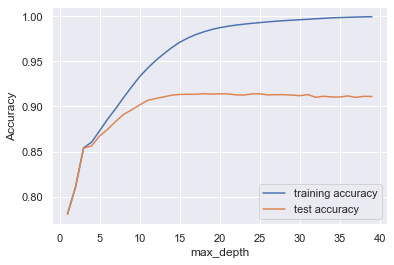

In [86]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### From above chart, we conclude max_depth = 10 is optimal

    ### Tuning min_samples_leaf

In [87]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, return_train_score = True,
                   scoring="accuracy")
tree.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [88]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.848909,0.094628,0.006010,0.000632,5,{'min_samples_leaf': 5},0.860047,0.908985,0.910409,0.909762,...,0.899943,0.019956,1,0.970350,0.963164,0.963003,0.963520,0.962163,0.964440,0.002988
1,1.444321,0.029108,0.005201,0.000400,25,{'min_samples_leaf': 25},0.858105,0.899922,0.895779,0.897721,...,0.888964,0.015584,2,0.924322,0.916521,0.913025,0.917978,0.914617,0.917292,0.003895
2,1.332328,0.061259,0.005406,0.000498,45,{'min_samples_leaf': 45},0.870274,0.887623,0.889177,0.889565,...,0.884872,0.007340,3,0.908267,0.900919,0.899625,0.900660,0.900408,0.901976,0.003175
3,1.164138,0.033467,0.005026,0.000022,65,{'min_samples_leaf': 65},0.866002,0.887235,0.884645,0.881797,...,0.880108,0.007400,4,0.900434,0.893086,0.891500,0.892406,0.894032,0.894292,0.003181
4,1.118334,0.037406,0.005396,0.000793,85,{'min_samples_leaf': 85},0.861212,0.881279,0.885293,0.881279,...,0.877622,0.008449,5,0.893183,0.889396,0.886483,0.888004,0.889306,0.889274,0.002223


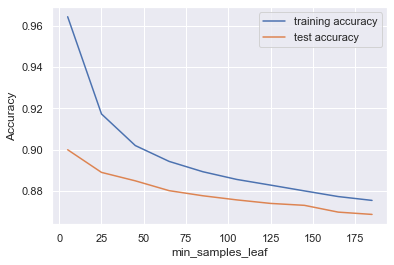

In [89]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### From above chart, we conclude min_samples_leaf = 25 is optimal

    ### Tuning min_samples_split

In [90]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, return_train_score = True,
                   scoring="accuracy")
tree.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [91]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.044302,0.116842,0.006395,0.000494,5,{'min_samples_split': 5},0.874935,0.917659,0.919860,0.915458,...,0.908695,0.016957,1,0.994141,0.993559,0.993332,0.992523,0.992135,0.993138,0.000722
1,2.029709,0.069215,0.006001,0.000030,25,{'min_samples_split': 25},0.864837,0.909503,0.909373,0.911315,...,0.900331,0.017811,2,0.965430,0.959604,0.957241,0.957467,0.957211,0.959391,0.003149
2,1.980302,0.048454,0.006016,0.000021,45,{'min_samples_split': 45},0.865873,0.905748,0.907043,0.902641,...,0.897302,0.015780,3,0.948663,0.944714,0.941218,0.943355,0.942776,0.944145,0.002522
3,2.051884,0.135737,0.006404,0.000487,65,{'min_samples_split': 65},0.863801,0.900181,0.903159,0.901476,...,0.894143,0.015202,4,0.941833,0.934324,0.932285,0.934712,0.934069,0.935445,0.003301
4,1.969097,0.081125,0.005600,0.000490,85,{'min_samples_split': 85},0.864966,0.896168,0.900440,0.900181,...,0.892511,0.013875,5,0.935068,0.926167,0.926199,0.928400,0.925880,0.928343,0.003482


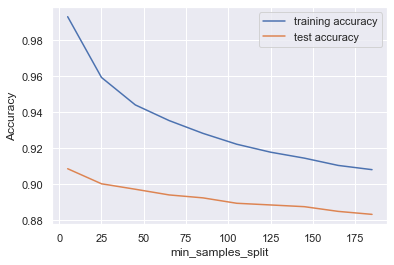

In [92]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### From above chart, we conclude min_samples_split = 50 is optimal

In [93]:
#Running the model with best parameters obtained from grid search

clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [94]:
# accuracy score
clf_gini.score(X_test,y_test)

0.8902344183979558

#### Key results from Decision Tree: 

    1. Accuracy c.89%
    2. 37 features were selected for model building
    3. Confusion Matric still show lot of false postives

#### 6e. Random Forest

In [95]:
#Let's first fit a random forest model with default hyperparameters
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [96]:
# fit
rfc.fit(X_lasso,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
# Making predictions
predictions = rfc.predict(X_test)

In [98]:
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, predictions))

Randon Forest Accuracy with Default Hyperparameter 0.928674591712032


In [99]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8251
           1       0.56      0.64      0.60       750

    accuracy                           0.93      9001
   macro avg       0.77      0.80      0.78      9001
weighted avg       0.93      0.93      0.93      9001



In [100]:
# Printing confusion matrix
print(confusion_matrix(y_test, predictions))

[[7879  372]
 [ 270  480]]


#### 6e.1 Cross-Validation for Random Forest

    6e.1 Hyperparameter Tuning Using Grid Search Cross-Validation
    
    ### Tuning max_depth

In [101]:
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=5, return_train_score = True,
                   scoring="accuracy")
rf.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [102]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.408583,0.012954,0.015423,0.001003,2,{'max_depth': 2},0.813956,0.807224,0.807613,0.822890,...,0.811979,0.005981,4,0.818767,0.817829,0.805205,0.818541,0.806189,0.813306,0.006229
1,1.113541,0.045612,0.021997,0.001548,7,{'max_depth': 7},0.872993,0.894096,0.895520,0.896556,...,0.890466,0.008814,3,0.903412,0.900660,0.899268,0.900434,0.902382,0.901231,0.001476
2,1.486914,0.035245,0.025993,0.001101,12,{'max_depth': 12},0.915588,0.934749,0.931901,0.933195,...,0.929774,0.007151,2,0.962290,0.961255,0.958147,0.958762,0.961257,0.960342,0.001599
3,1.978491,0.197843,0.032009,0.003939,17,{'max_depth': 17},0.925557,0.948343,0.944329,0.948343,...,0.942747,0.008720,1,0.986017,0.984916,0.982424,0.981874,0.984237,0.983894,0.001544


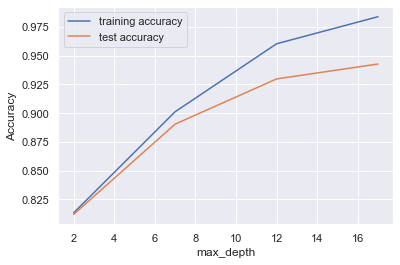

In [103]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


    ### Tuning min_sample_leaf

In [104]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score = True,
                   scoring="accuracy")
rf.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [105]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.244332,0.070785,0.024030,0.001544,100,{'min_samples_leaf': 100},0.877266,0.885034,0.891248,0.885293,...,0.885934,0.005071,1,0.899722,0.885641,0.888781,0.888457,0.890471,0.890614,0.004811
1,1.178743,0.066384,0.026000,0.002967,150,{'min_samples_leaf': 150},0.859399,0.883092,0.883868,0.880502,...,0.877803,0.009270,2,0.887519,0.884605,0.883990,0.881595,0.883124,0.884167,0.001957
2,1.059553,0.059252,0.022399,0.000490,200,{'min_samples_leaf': 200},0.856680,0.878172,0.881797,0.883221,...,0.876042,0.009824,3,0.880203,0.879556,0.877096,0.879297,0.881894,0.879609,0.001549
3,0.969956,0.021576,0.021418,0.001350,250,{'min_samples_leaf': 250},0.858752,0.870016,0.879855,0.875842,...,0.872495,0.007627,4,0.880074,0.874053,0.873082,0.873827,0.876424,0.875492,0.002550
4,0.981947,0.115897,0.022799,0.002227,300,{'min_samples_leaf': 300},0.853962,0.871181,0.875842,0.870792,...,0.868740,0.007605,5,0.874862,0.874571,0.873535,0.871399,0.870533,0.872980,0.001724


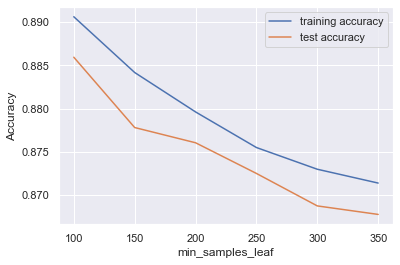

In [106]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

    ### Tuning max_sample_split

In [107]:
# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score = True,
                   scoring="accuracy")
rf.fit(X_lasso, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [108]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.793912,0.115413,0.028988,0.001799,200,{'min_samples_split': 200},0.877913,0.904583,0.900958,0.900440,...,0.896758,0.009565,1,0.914611,0.910630,0.911569,0.903994,0.908953,0.909951,0.003501
1,1.726707,0.104839,0.029005,0.005018,250,{'min_samples_split': 250},0.879078,0.897980,0.901088,0.899275,...,0.894842,0.008010,2,0.907814,0.902311,0.902538,0.900596,0.901605,0.902973,0.002513
2,1.665336,0.191231,0.027583,0.003265,300,{'min_samples_split': 300},0.872346,0.899275,0.899275,0.895909,...,0.892874,0.010340,3,0.904674,0.903671,0.901081,0.897456,0.901379,0.901652,0.002499
3,1.524929,0.042892,0.026398,0.000489,350,{'min_samples_split': 350},0.874029,0.892413,0.895003,0.895132,...,0.888653,0.007927,5,0.903509,0.895028,0.898815,0.897521,0.891410,0.897257,0.004018
4,1.633721,0.150011,0.025611,0.000814,400,{'min_samples_split': 400},0.870792,0.889824,0.893320,0.897851,...,0.888886,0.009407,4,0.898297,0.892827,0.894640,0.896129,0.893449,0.895068,0.001969


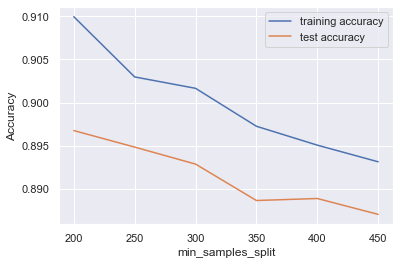

In [109]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [110]:
# Grid Search to Find Optimal Hyperparameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [111]:
# Fit the grid search to the data
grid_search.fit(X_lasso, y_train_res)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 27.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [112]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8865554922574965 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [113]:
#Fitting the final model with the best parameters obtained from grid search
# model with the best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=15,
                             n_estimators=1000)

rf.fit(X_train, y_train)

# Make predictions
predictions = rf.predict(X_test)

In [114]:
#Evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8271
           1       0.71      0.40      0.51       730

    accuracy                           0.94      9001
   macro avg       0.83      0.69      0.74      9001
weighted avg       0.93      0.94      0.93      9001

[[8152  119]
 [ 436  294]]


In [115]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, predictions))

Accuracy Score for Random Forest Final Model : 0.9383401844239528


## List of Features in the order of Importance

In [119]:
pd.concat((pd.DataFrame(X_test_cols, columns = ['variable']),pd.DataFrame(rf.feature_importances_, columns = ['importance'])), axis = 1).sort_values(by = 'importance', ascending = False)

,variable,importance
14,loc_ic_t2m_mou_8,0.115742
13,loc_ic_t2t_mou_8,0.062519
6,loc_og_t2m_mou_8,0.055081
24,last_day_rch_amt_8,0.037003
0,arpu_8,0.036309
2,offnet_mou_8,0.034194
25,vol_2g_mb_8,0.033219
23,max_rech_amt_8,0.030400
31,aon,0.027864
36,avg_offnet_mou_av67,0.027631


### To find the list of customers expected to Churn

In [120]:
predictions[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [121]:
# Converting predictions to a dataframe which is an array
rf_y_pred = pd.DataFrame(predictions)
rf_y_pred.head()

,0
0,0
1,0
2,1
3,0
4,0


In [122]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [123]:
# Removing index for both dataframes to append them side by side 
rf_y_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [124]:
# Appending y_test_df and rf_y_pred
y_pred_final = pd.concat([y_test_df, rf_y_pred],axis=1)

y_pred_final.head()

,churn,CustID,0
0,0,19969,0
1,0,95615,0
2,1,41661,1
3,0,76716,0
4,0,49503,0


In [127]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Predicted_churn'})

In [130]:
y_pred_final.loc[y_pred_final['Predicted_churn'] == 1]

,churn,CustID,Predicted_churn
2,1,41661,1
15,0,77543,1
35,1,99436,1
74,1,22126,1
87,1,51065,1
...,...,...,...
8810,1,99058,1
8884,0,89353,1
8925,0,65782,1
8958,0,38326,1


## Key results from Random Forest:

Based on our analysis, we recommended Telecome company on below points to concentrate to avoid customer churn.

   - Customer churn rate is minimal which is a good sign of service provided.
   
   - 413 customers are predicted to churn in the month of September.
   
   - Features "loc_ic_t2m_mou_8", "loc_ic_t2t_mou_8", "loc_og_t2m_mou_8", "last_day_rch_amt_8", "arpu_8" are the top 5 contributing for customer churn. Hence, company should try to improve on these features to achieve customer churn.
    